In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Setup output directory
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/DL_2025/8/'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/", exist_ok=True)

Mounted at /content/drive


In [2]:
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Add Gaussian noise
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
def build_denoising_autoencoder():
    input_img = keras.Input(shape=(32, 32, 3))

    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    return autoencoder

autoencoder = build_denoising_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

# Save training history
pd.DataFrame(history.history).to_csv(f"{OUTPUT_DIR}/loss_history.csv", index=False)


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0198 - val_loss: 0.0079
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


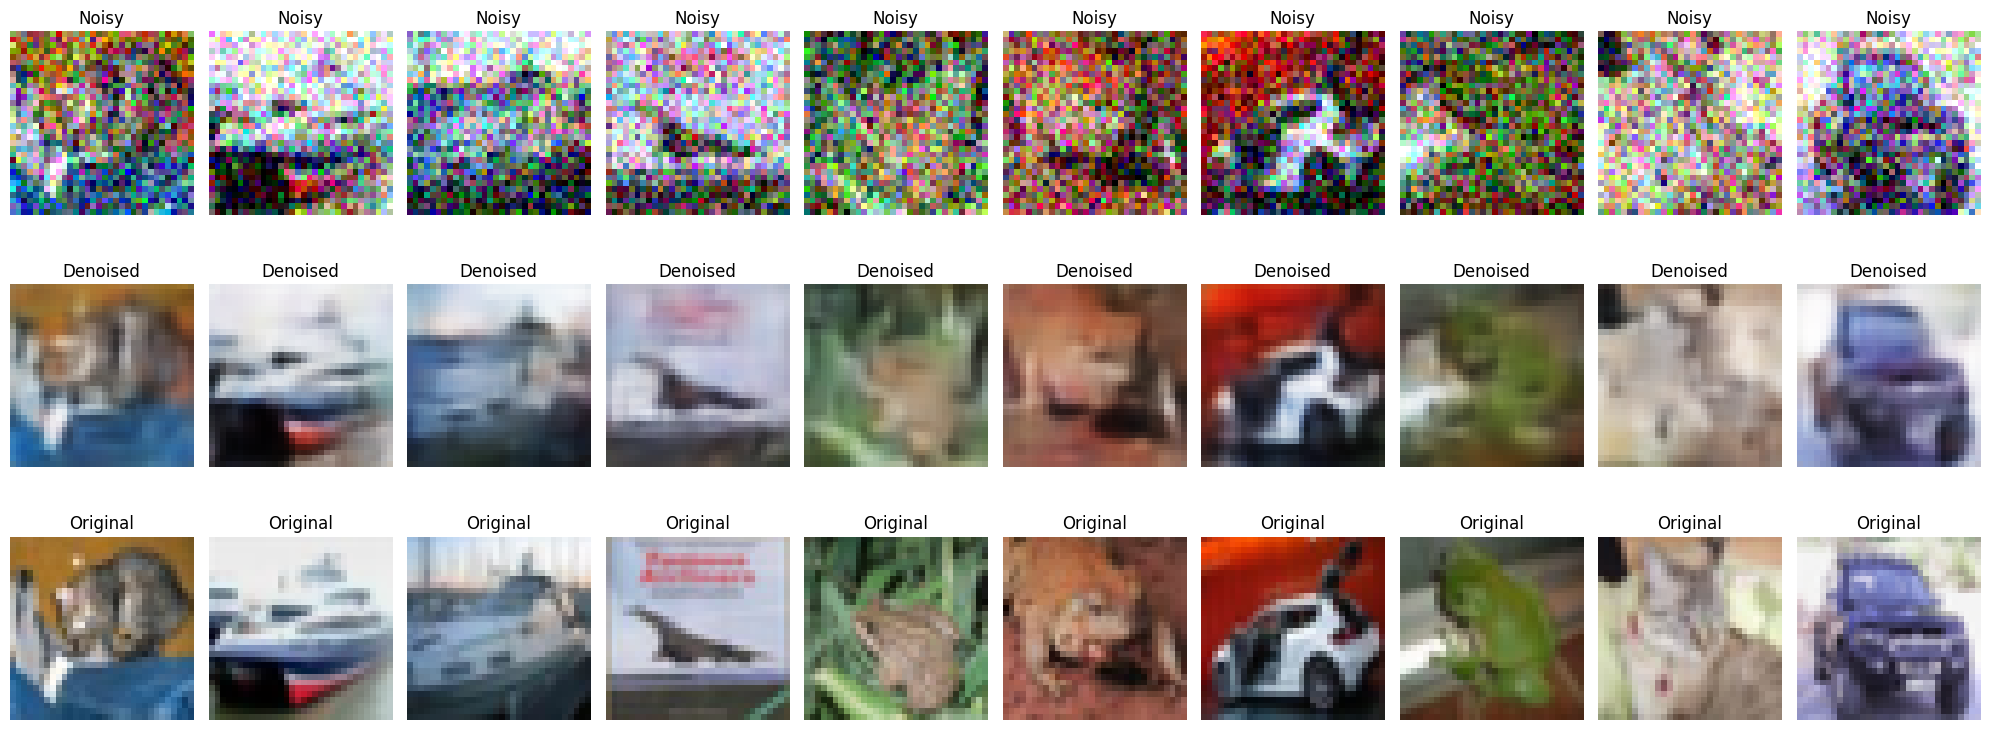

In [6]:
# Pick 10 test images
num_images = 10
decoded_imgs = autoencoder.predict(x_test_noisy[:num_images])

plt.figure(figsize=(20, 8))
for i in range(num_images):
    # Noisy
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    # Denoised
    ax = plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised")
    plt.axis("off")

    # Original
    ax = plt.subplot(3, num_images, i + 1 + 2*num_images)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/sample_denoising_results.png")
plt.show()
